<a href="https://colab.research.google.com/github/rodrigocan/made-with-ml/blob/main/notebooks/06_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão linear

Nesta aula, aprenderemos sobre regressão linear. Entenderemos a matemática básica por trás desse, implementaremos o algoritmo do zero utilizando o NumPy e depois o PyTorch.

# Visão geral

Nosso objetivo é aprender um modelo linear $\hat{y}$ que modela $y$ com os dados de $X$.

$\hat{y} = XW + b$, onde:

* $\hat{y}$ = * $\hat{y}$ = previsões | $\in \mathbb{R}^{NX1}$ ($N$ é o número de amostras)
* $X$ = dados de entrada | $\in \mathbb{R}^{NXD}$ ($D$ é o número de variáveis)
* $W$ = pesos | $\in \mathbb{R}^{DX1}$
* $b$ = viés | $\in \mathbb{R}^{1}$

- **Objetivo**: Utilizar os dados de entrada $X$ para prever a saída $\hat{y}$ usando um modelo linear. O modelo será uma reta de melhor ajuste que minimiza a distância entre o valores previstos (saídas do modelo) e os valores alvo (valores reais). Os dados de treinamento $(X, y)$ são utilizados para treinar o modelo e aprender os pesos $W$ usando gradiente descendente.

* **Vantagens**:

 * Computacionalmente simples.
 * Altamente interpretável.
 * Pode lidar com variáveis contínuas e categóricas.

* **Desvantagens**:

 * O modelo funcionará bem somente quando os dados forem linearmente separáveis (para classificação).
 * Geralmente não é utilizado para classificação e apenas para regressão.

* Você também pode usar o modelo de regressão linear para tarefas de classificação binária, onde se o valor predito for acima de determinado limite, pertencerá a determinada classe. Entretanto, Iremos aprender técnicas melhores de classificação nas próximas aulas e vamos focar o modelo de regressão linear para tarefas de regressão de valores contínuos somente.

# Gerando dados

Vamos gerar alguns dados fictícios simples para aplicação da regressão linear. Criaremos dados aproximadamente lineares (y = 3,5X + ruído); o ruído aleatório é adicionado para criar dados que não se alinham perfeitamente em uma reta. Nosso objetivo é fazer com que o modelo convirja para uma equação linear semelhante (haverá uma pequena variação, uma vez que adicionamos o ruído).

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [237]:
SEED = 1234
NUM_SAMPLES = 50

In [238]:
# Definindo um seed, para que seja possível reproduzir os resultados em outro ambiente
np.random.seed(SEED)

In [239]:
# Gerando dados fictícios aleatórios
def generate_data(num_samples):
  """"Gerando dados fictícios aleatórios para regressão linear"""
  X = np.array(range(num_samples))
  random_noise = np.random.uniform(-10,20,size=num_samples)
  y = 3.5*X + random_noise # add some noise
  return X, y

In [240]:
# Gerando dados lineares aleatórios
X, y = generate_data(num_samples=NUM_SAMPLES)
data = np.vstack([X, y]).T
print (data[:5])

[[ 0.         -4.25441649]
 [ 1.         12.16326313]
 [ 2.         10.13183217]
 [ 3.         24.06075751]
 [ 4.         27.39927424]]


In [241]:
# Carregando os dados dentro de um dataframe do Pandas
df = pd.DataFrame(data, columns=["X", "y"])
X = df[["X"]].values
y = df[["y"]].values
df.head()

,X,y
0,0.0,-4.254416
1,1.0,12.163263
2,2.0,10.131832
3,3.0,24.060758
4,4.0,27.399274


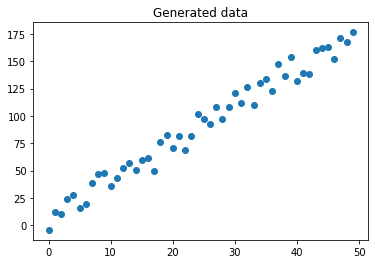

In [242]:
# Gráfico de dispersão
plt.title("Generated data")
plt.scatter(x=df["X"], y=df["y"])
plt.show()

# NumPy

Agora que preparamos nossos dados, vamos primeiro implementar a regressão linear usando apenas o NumPy. Isso nos permitirá entender as operações que estão por trás do modelo.

## Divisão dos dados

Dividiremos aleatoriamente nosso conjunto de dados em outros três conjuntos: treinamento, validação e teste.

* `train`: usado para treinar nosso modelo.
* `val`: usado para validar o desempenho do nosso modelo durante o treinamento.
* `test`: usado para avaliação do nosso modelo treinado.

In [243]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [244]:
# Embaralhando os dados
indices = list(range(NUM_SAMPLES))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

> Tome cuidado para não embaralhar X e y separadamente, pois assim os dados de entrada não corresponderão aos dados de saída!

In [245]:
# Dividindo os índices
train_start = 0
train_end = int(0.7*NUM_SAMPLES)
val_start = train_end
val_end = int((TRAIN_SIZE+VAL_SIZE)*NUM_SAMPLES)
test_start = val_end

In [246]:
# Dividindo os dados
X_train = X[train_start:train_end]
y_train = y[train_start:train_end]
X_val = X[val_start:val_end]
y_val = y[val_start:val_end]
X_test = X[test_start:]
y_test = y[test_start:]
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (35, 1), y_train: (35, 1)
X_val: (7, 1), y_val: (7, 1)
X_test: (8, 1), y_test: (8, 1)


## Padronizando os dados

Precisamos padronizar nossos dados (média zero e variância 1). Dessa forma, a magnitude de uma variável não vai afetar no modo como o modelo aprende os pesos. Faremos isso com o z-score:

$z = \frac{x_i - \mu}{\sigma}$, onde:

* $z$ = valor padronizado
* $x_i$ = dados de entrada
* $\mu$ = média
* $\sigma$ = desvio-padrão

In [247]:
def standardize_data(data, mean, std):
    return (data - mean)/std

In [248]:
# Calculando médias e desvios-padrão
X_mean = np.mean(X_train)
X_std = np.std(X_train)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

Precisamos tratar os conjuntos de validação e teste como se fossem conjuntos de dados ocultos. Assim, usamos apenas o conjunto de treinamento para determinar a média e o desvio-padrão, evitando o enviesamento do nosso processo de treinamento.

In [249]:
# Padronizando
X_train = standardize_data(X_train, X_mean, X_std)
y_train = standardize_data(y_train, y_mean, y_std)
X_val = standardize_data(X_val, X_mean, X_std)
y_val = standardize_data(y_val, y_mean, y_std)
X_test = standardize_data(X_test, X_mean, X_std)
y_test = standardize_data(y_test, y_mean, y_std)

In [250]:
# Checando
print (f"mean: {np.mean(X_test, axis=0)[0]:.1f}, std: {np.std(X_test, axis=0)[0]:.1f}")
print (f"mean: {np.mean(y_test, axis=0)[0]:.1f}, std: {np.std(y_test, axis=0)[0]:.1f}")

mean: -0.6, std: 0.9
mean: -0.6, std: 0.9


## Pesos

Nosso objetivo é aprender um modelo linear $\hat{y}$ que modela $y$ dado que $X$.

$\hat{y} = XW + b$
* $\hat{y}$ = previsões | $\in \mathbb{R}^{NX1}$ ($N$ é o número de amostras)
* $X$ = dados de entrada | $\in \mathbb{R}^{NXD}$ ($D$ é o número de variáveis)
* $W$ = pesos | $\in \mathbb{R}^{DX1}$ 
* $b$ = viés | $\in \mathbb{R}^{1}$ 

1. Iniciando os pesos $W$ com valores aleatórios.

In [251]:
INPUT_DIM = X_train.shape[1] # X é unidimensional
OUTPUT_DIM = y_train.shape[1] # y é unidimensional

In [252]:
# Iniciando os pesos com valores aleatórios
W = 0.01 * np.random.randn(INPUT_DIM, OUTPUT_DIM)
b = np.zeros((1, 1))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (1, 1)
b: (1, 1)


## Modelo

2. Alimentando o modelo com os dados de entrada $X$ para receber as previsões $\hat{y}$.
  * $\hat{y} = XW + b$

In [253]:
# Forward pass [N x 1] . [1 x 1] = [N x 1]
y_pred = np.dot(X_train, W) + b
print (f"y_pred: {y_pred.shape}")

y_pred: (35, 1)


## Perda

3. Agora vamos comparar as previsões $\hat{y}$ com os valores-alvo verdadeiros $y$ usando a função objetivo para determinar a perda $J$. Uma função objetivo comum para a regressão linear é o erro quadrático médio (MSE). Esta função calcula a diferença entre os valores preditos e alvo e a eleva ao quadrado.

* $ J(\theta) = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2  = \frac{1}{N}\sum_i (y_i - X_iW)^2 $, onde:
    * ${y}$ = valores-alvo (verdadeiros) | $\in \mathbb{R}^{NX1}$
    * $\hat{y}$ = valores preditos | $\in \mathbb{R}^{NX1}$
    * termo do viés ($b$) - omitido para a equação não ficar muito grande

In [254]:
# Loss
N = len(y_train)
loss = (1/N) * np.sum((y_train - y_pred)**2)
print (f"loss: {loss:.2f}")

loss: 0.99


## Gradientes

4. Calculando os gradientes da perda $J(\theta)$ com os pesos do modelo.
  * $\frac{\partial{J}}{\partial{W}} = -\frac{2}{N} \sum_i (y_i - X_iW) X_i = -\frac{2}{N} \sum_i (y_i - \hat{y}_i) X_i$
  * $\frac{\partial{J}}{\partial{b}} = -\frac{2}{N} \sum_i (y_i - X_iW)1 = -\frac{2}{N} \sum_i (y_i - \hat{y}_i)1$

In [255]:
# Backpropagation
dW = -(2/N) * np.sum((y_train - y_pred) * X_train)
db = -(2/N) * np.sum((y_train - y_pred) * 1)

> O gradiente é a derivada (a taxa de variação de uma função). É o vetor que apontar na direção de maior crescimento da função. No caso em análise, o gradiente da nossa função de perda ($J$) com relação aos pesos ($W$) nos dirá como mudar W para maximizar ($J$). No entanto, queremos minimizar a nossa perda. Dessa forma, subtraímos o gradiente de $W$.

## Atualizando os pesos

5. Atualizando os pesos $W$ usando uma pequena taxa de aprendizado $\alpha$.

  * $W = W - \alpha\frac{\partial{J}}{\partial{W}}$
  * $b = b - \alpha\frac{\partial{J}}{\partial{b}}$

In [256]:
LEARNING_RATE = 1e-1

In [257]:
# Atualizando os pesos
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

> A taxa de aprendizado $\alpha$ é uma forma de controlar o quanto atualizamos os pesos. Se escolhermos uma taxa de aprendizado pequena, nosso modelo pode demorar muito para ser treinado. Por outro lado, se escolhermos uma taxa de aprendizado grande, podemos ultrapassar e nosso treinameno nunca irá convergir. A especificação da taxa de aprendizado depende de nossos dados e do tipo de modelos que usamos, mas normalmente é bom adotar algo no intervalo de $[1e^{-8}, 1e^{-1}]$. Vamos explorar estratégias de atualização da taxa de aprendizado em lições posteriores.

## Treinamento

6. Repetindo os passos 2 - 5 para minimizar a perda e treinar o modelo.

In [258]:
NUM_EPOCHS = 100

In [259]:
# Inicializando com pesos aleatórios
W = 0.01 * np.random.randn(INPUT_DIM, OUTPUT_DIM)
b = np.zeros((1, ))

# Loop de treinamento
for epoch_num in range(NUM_EPOCHS):

  # Forward pass [N x 1] . [1 x 1] = [N x 1]
  y_pred = np.dot(X_train, W) + b

  # Perda
  loss = (1/len(y_train)) * np.sum((y_train - y_pred)**2)

  # Mostrando progresso
  if epoch_num%10 == 0:
      print (f"Epoch: {epoch_num}, loss: {loss:.3f}")

  # Backpropagation
  dW = -(2/N) * np.sum((y_train - y_pred) * X_train)
  db = -(2/N) * np.sum((y_train - y_pred) * 1)

  # Atualizando os pesos
  W += -LEARNING_RATE * dW
  b += -LEARNING_RATE * db

Epoch: 0, loss: 0.990
Epoch: 10, loss: 0.039
Epoch: 20, loss: 0.028
Epoch: 30, loss: 0.028
Epoch: 40, loss: 0.028
Epoch: 50, loss: 0.028
Epoch: 60, loss: 0.028
Epoch: 70, loss: 0.028
Epoch: 80, loss: 0.028
Epoch: 90, loss: 0.028


## Avaliação

In [260]:
# Previsões
pred_train = W * X_train + b
pred_test = W * X_test + b

# Erro quadrático médio (MSE) dos dados de treinamento e teste
train_mse = np.mean((y_train - pred_train) ** 2)
test_mse = np.mean((y_test - pred_test) ** 2)
print(f"train_MSE: {train_mse:.2f}, test_MSE: {test_mse:.2f}")

train_MSE: 0.03, test_MSE: 0.01


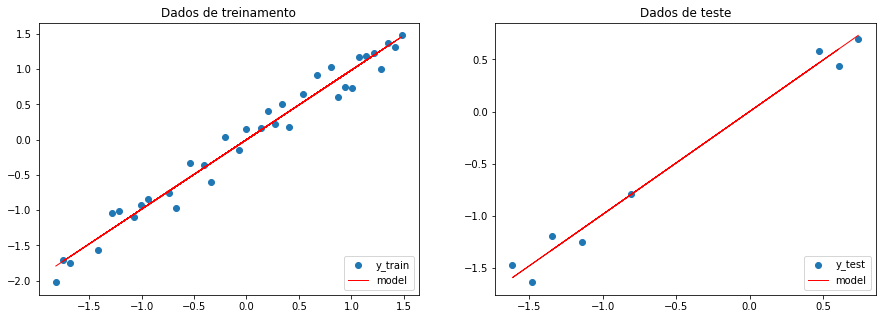

In [261]:
# Tamanho do gráfico
plt.figure(figsize = (15, 5))

# Plotando dados de treinamento
plt.subplot(1, 2, 1)
plt.title("Dados de treinamento")
plt.scatter(X_train, y_train, label = "y_train")
plt.plot(X_train, pred_train, color = "red", linewidth = 1, linestyle = "-", label = "model")
plt.legend(loc = "lower right")

# Plotando dados de teste
plt.subplot(1, 2, 2)
plt.title("Dados de teste")
plt.scatter(X_test, y_test, label = "y_test")
plt.plot(X_test, pred_test, color = "red", linewidth = 1, linestyle = "-", label = "model")
plt.legend(loc = "lower right")

## Interpretabilidade

Uma vez que nós padronizamos nossos dados de entrada e saída, nossos pesos se ajustaram a esses valores padronizados. Dessa forma, precisamos "despadronizar" nossos pesos para poder compará-los com os valores reais (3,5).

Note que tanto X quanto y foram padronizados.

$\hat{y}_{scaled} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}x_{{scaled}_j}$
* $y_{scaled} = \frac{\hat{y} - \bar{y}}{\sigma_y}$
* $x_{scaled} = \frac{x_j - \bar{x}_j}{\sigma_j}$

$\frac{\hat{y} - \bar{y}}{\sigma_y} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}\frac{x_j - \bar{x}_j}{\sigma_j}$

$ \hat{y}_{scaled} = \frac{\hat{y}_{unscaled} - \bar{y}}{\sigma_y} = {b_{scaled}} + \sum_{j=1}^{k} {W}_{{scaled}_j} (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y}_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})\bar{x}_j + \sum_{j=1}^{k}{W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})x_j $

In the expression above, we can see the expression $\hat{y}_{unscaled} = W_{unscaled}x + b_{unscaled} $ where

* $W_{unscaled} = \sum_{j=1}^{k}{W}_j(\frac{\sigma_y}{\sigma_j}) $

* $b_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_j(\frac{\sigma_y}{\sigma_j})\bar{x}_j$

In [262]:
# Pesos não padronizados
W_unscaled = W * (y_std / X_std)
b_unscaled = b * y_std + y_mean - np.sum(W_unscaled * X_mean)
print("[actual] y = 3.5X + noise")
print(f"[model] y_hat = {W_unscaled[0][0]:.1f}X + {b_unscaled[0]:.1f}")

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 7.8


# PyTorch

Agora que implementamos a regressão linear com o NumPy, vamos fazer o mesmo com o PyTorch.

In [263]:
import torch

In [264]:
# Definindo um seed, para que seja possível reproduzir os resultados em outro ambiente
torch.manual_seed(SEED)

## Divisão dos dados

Dessa vez, ao invés de dividirmos os dados usando índices, vamos usar a função `train_test_split` do scikit-learn. Essa função vai dividir um conjunto de dados em 2 subconjuntos, então vamos usá-la duas vezes para criar nossos três conjuntos de dados.

In [265]:
from sklearn.model_selection import train_test_split

In [266]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [267]:
# Conjunto de treinamento
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE)

In [268]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 35 (0.70)
remaining: 15 (0.30)


In [269]:
# Conjunto de teste
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [270]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 35 (0.70)
val: 7 (0.14)
test: 8 (0.16)


## Padronizando os dados

Dessa vez, vamos utilizar o scikit-learn para [pré-processamento e padronização](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

In [271]:
from sklearn.preprocessing import StandardScaler

In [272]:
# Padronizando os dados (média = 0, desvio-padrão = 1) usando os dados de treinamento
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [273]:
# Aplicando o scaler aos conjuntos de treinamento e teste
X_train = X_scaler.transform(X_train)
y_train = y_scaler.transform(y_train).ravel().reshape(-1, 1)
X_val = X_scaler.transform(X_val)
y_val = y_scaler.transform(y_val).ravel().reshape(-1, 1)
X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test).ravel().reshape(-1, 1)

In [274]:
# Checando
print(f"mean: {np.mean(X_test, axis=0)[0]:.1f}, std: {np.std(X_test, axis=0)[0]:.1f}")
print(f"mean: {np.mean(y_test, axis=0)[0]:.1f}, std: {np.std(y_test, axis=0)[0]:.1f}")

mean: -0.5, std: 0.8
mean: -0.5, std: 0.8


## Pesos

Vamos usar os [Linear layers](https://pytorch.org/docs/stable/nn.html#linear-layers) do PyTorch. Esses layers serão nossos pesos (e viéses).

$ z = XW $

In [275]:
from torch import nn

In [276]:
# Dados de entrada
N = 3 # número de amostras
x = torch.randn(N, INPUT_DIM)
print(x.shape)
print(x.numpy())

torch.Size([3, 1])
[[ 0.04613046]
 [ 0.40240282]
 [-1.0115291 ]]


In [277]:
# Pesos
m = nn.Linear(INPUT_DIM, OUTPUT_DIM)
print(m)
print(f"pesos ({m.weight.shape}): {m.weight[0][0]:.2f}")
print(f"viés ({m.bias.shape}): {m.bias[0]:.2f}")

Linear(in_features=1, out_features=1, bias=True)
pesos (torch.Size([1, 1])): 0.35
viés (torch.Size([1])): -0.34


In [278]:
# Forward pass
z = m(x)
print(z.shape)
print(z.detach().numpy())

torch.Size([3, 1])
[[-0.32104054]
 [-0.19719592]
 [-0.68869597]]


## Modelo

Nosso objetivo é aprender um modelo linear $\hat{y}$ que modela $y$ com os dados de $X$.

$\hat{y} = XW + b$, onde:

* $\hat{y}$ = * $\hat{y}$ = previsões | $\in \mathbb{R}^{NX1}$ ($N$ é o número de amostras)
* $X$ = dados de entrada | $\in \mathbb{R}^{NXD}$ ($D$ é o número de variáveis)
* $W$ = pesos | $\in \mathbb{R}^{DX1}$
* $b$ = viés | $\in \mathbb{R}^{1}$

In [279]:
from torchsummary import summary

In [280]:
class LinearRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LinearRegression, self).__init__()
    self.fc1 = nn.Linear(input_dim, output_dim)

  def forward(self, x_in):
    y_pred = self.fc1(x_in)
    return y_pred

In [281]:
# Instanciando o modelo
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
print(model.named_parameters)

<bound method Module.named_parameters of LinearRegression(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)>


## Perda

Dessa vez vamos utilizar as [funções de perda](https://pytorch.org/docs/stable/nn.html#loss-functions) do PyTorch, especificamente a [`MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss).

In [282]:
loss_fn = nn.MSELoss()
y_pred = torch.Tensor([0, 0, 1, 1])
y_true = torch.Tensor([1, 1, 1, 0])
loss = loss_fn(y_pred, y_true)
print("Loss: ", loss.numpy())

Loss:  0.75


## Otimizador

Quando implementamos a regressão linear apenas com o NumPy, usamos o gradiente descendente em lote para atualizar nossos pesos. Mas existem muitos [algoritmos de otimização] (https://pytorch.org/docs/stable/optim.html) diferentes para escolher, dependendo da situação. No entando, o [otimizador ADAM](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) tornou-se um algoritmo padrão para a maioria dos casos.

In [283]:
from torch.optim import Adam

In [284]:
# Otimizador
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

## Treinamento

In [285]:
# Convertendo os dados para tensores
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [286]:
# Treinamento
for epoch in range(NUM_EPOCHS):
  # Forward pass
  y_pred = model(X_train)

  # Perda
  loss = loss_fn(y_pred, y_train)

  # Zero all gradientes
  optimizer.zero_grad()

  # Backward pass
  loss.backward()

  # Atualizando pesos
  optimizer.step()

  if epoch%20==0:
    print(f"Epoch: {epoch} | perda: {loss:.2f}")

Epoch: 0 | perda: 0.22
Epoch: 20 | perda: 0.03
Epoch: 40 | perda: 0.02
Epoch: 60 | perda: 0.02
Epoch: 80 | perda: 0.02


## Avaliação

Agora podemos avaliar o nosso modelo treinado.

In [287]:
# Previsões
pred_train = model(X_train)
pred_test = model(X_test)

In [288]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f"train_error: {train_error:.2f}")
print(f"test_error: {test_error:.2f}")

train_error: 0.02
test_error: 0.01


Como temos apenas uma variável, é fácil inespecionar visualmente o modelo.

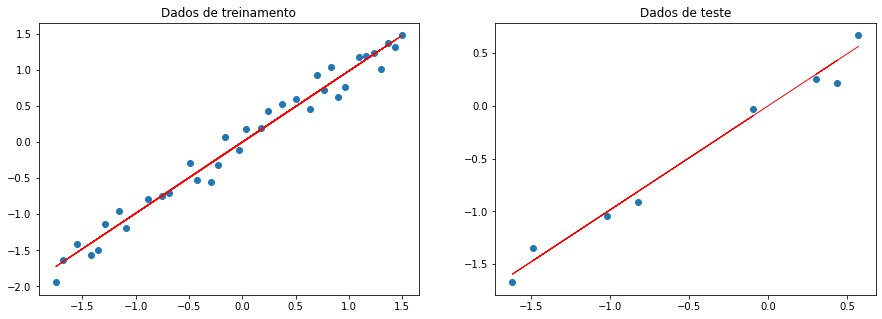

In [289]:
# Figure size
plt.figure(figsize=(15,5))

# Plotando dados de treinamento
plt.subplot(1, 2, 1)
plt.title("Dados de treinamento")
plt.scatter(X_train, y_train, label="y_train")
plt.plot(X_train, pred_train.detach().numpy(), color="red", linewidth=1, linestyle="-", label="model")

# Plotando dados de teste
plt.subplot(1, 2, 2)
plt.title("Dados de teste")
plt.scatter(X_test, y_test, label="y_test")
plt.plot(X_test, pred_test.detach().numpy(), color="red", linewidth=1, linestyle="-", label="model")

# Mostrando gráficos
plt.show()

## Inferência

Depois de treinar nosso modelo, podemos utilizá-lo para previsão em novos dados.

In [290]:
# Coloque os seus inputs
sample_indices = [10, 15, 25]
X_infer = np.array(sample_indices, dtype=np.float32)
X_infer = torch.Tensor(X_scaler.transform(X_infer.reshape(-1, 1)))

Lembre-se de que precisamos "despadronizar" nossas previsões.

$ \hat{y}_{scaled} = \frac{\hat{y} - \mu_{\hat{y}}}{\sigma_{\hat{y}}} $

$ \hat{y} = \hat{y}_{scaled} * \sigma_{\hat{y}} + \mu_{\hat{y}} $

In [291]:
# "Despadronizando" as previsões
pred_infer = model(X_infer).detach().numpy() * np.sqrt(y_scaler.var_) + y_scaler.mean_
for i, index in enumerate(sample_indices):
    print (f"{df.iloc[index]['y']:.2f} (actual) → {pred_infer[i][0]:.2f} (predicted)")

35.73 (actual) → 41.86 (predicted)
59.34 (actual) → 59.10 (predicted)
97.04 (actual) → 93.58 (predicted)


## Interpretabilidade



A regressão linear tem a grande vantagem de ser altamente interpretável. Cada variável tem um coeficiente que significa sua importância/impacto na variável de saída y. Podemos interpretar nossos coeficientes como o seguinte: ao aumentar X em 1 unidade, aumentamos y em W unidades.

In [292]:
# "Despadronizando" os coeficientes
W = model.fc1.weight.data.numpy()[0][0]
b = model.fc1.bias.data.numpy()[0]
W_unscaled = W * (y_scaler.scale_/X_scaler.scale_)
b_unscaled = b * y_scaler.scale_ + y_scaler.mean_ - np.sum(W_unscaled*X_scaler.mean_)
print("[actual] y = 3.5X + noise")
print(f"[model] y_hat = {W_unscaled[0]:.1f}X + {b_unscaled[0]:.1f}")

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 7.4


# Regularização

A regularização ajuda a diminuir o super-ajuste (overfitting). Abaixo temos a regularização `L2` (regressão de Ridge). Existem diversas formas de regularização. Com a regularização `L2`, nós estamos penalizando os pesos com grandes magnitude, reduzindo-os. Ter certos pesos com altas magnitudes levará a um viés preferencial com as entradas e queremos que o modelo funcione com todas as entradas, não apenas com algumas selecionadas. Existe também a regularização `L1` (regressão de Lasso), que serve para criar modelos esparsos, onde alguns coeficientes são zerados. Existem também a regularização elástica, que combina as penalidades `L1` e `L2`.

> A regularização não é usada apenas na regressão linear. Podemos utilizá-la para regularizar os pesos de quaisquer modelos, incluindo os que vamos aprender em aulas futuras.

$ J(\theta) = \frac{1}{2}\sum_{i}(X_iW - y_i)^2 + \frac{\lambda}{2}W^TW$

$ \frac{\partial{J}}{\partial{W}}  = X (\hat{y} - y) + \lambda W $

$W = W- \alpha\frac{\partial{J}}{\partial{W}}$, onde:

* $\lambda$ é o coeficiente de regularização
* $\alpha$ é a taxa de aprendizado

No PyTorch, podemos adicionar a regularização L2 ajustando o nosso otimizador. O otimizador Adam tem um parâmetro `weight_decay` que controla a penalidade L2.

In [293]:
L2_LAMBDA = 1e-2

In [294]:
# Instanciando o modelo
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)

In [295]:
# Otimizador (com regularização L2)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

In [296]:
# Treinamento
for epoch in range(NUM_EPOCHS):
  # Forward pass
  y_pred = model(X_train)

  # Loss
  loss = loss_fn(y_pred, y_train)

  # Zero all gradientes
  optimizer.zero_grad()

  # Backward pass
  loss.backward()

  # Atualizando pesos
  optimizer.step()

  if epoch%20==0:
    print(f"Epoch: {epoch} | loss: {loss:.2f}")

Epoch: 0 | loss: 0.63
Epoch: 20 | loss: 0.04
Epoch: 40 | loss: 0.02
Epoch: 60 | loss: 0.02
Epoch: 80 | loss: 0.02


In [297]:
# Previsões
pred_train = model(X_train)
pred_test = model(X_test)

In [298]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f"train_error: {train_error:.2f}")
print(f"test_error: {test_error:.2f}")

train_error: 0.02
test_error: 0.01


A regularização não fez diferença na performance desse modelo específico, porque nosso dados são gerados de uma equação linear perfeita mas, para dados reais, a regularização pode ajudar nosso modelo a generalizar bem.